In [47]:
from joblib import load
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
%matplotlib inline

In [2]:
clf = load("./sgd_clf.joblib")

In [3]:
# https://stackoverflow.com/questions/59165149/plot-confusion-matrix-with-scikit-learn-without-a-classifier
def get_stats(y_test, y_pred):
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    recall =  sklearn.metrics.recall_score(y_test, y_pred)
    f1 =  sklearn.metrics.f1_score(y_test, y_pred)
    
    print("accuracy: ", round(accuracy, 2))
    print("precision: ", round(precision, 2))
    print("recall: ", round(recall, 2))
    print("f1 score: ", round(f1, 2), "\n")
    
    print("classification report")
    print(sklearn.metrics.classification_report(y_test, y_pred))
    
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0, 1]))
    disp = disp.plot(include_values=True, cmap="Blues", values_format=".7g")
    plt.show()

In [8]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection, svm
from sklearn.ensemble import RandomForestClassifier
import numpy as np

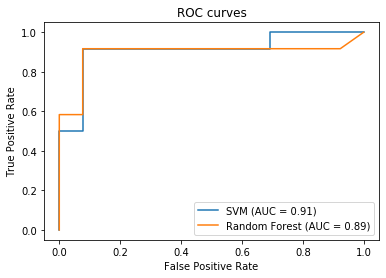

In [48]:
X, y = datasets.make_classification(random_state=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)

svc_clf = svm.SVC(random_state=0)
svc_clf.fit(X_train, y_train)

forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train, y_train)
y_score = forest_clf.predict_proba(X_test)
y_score = y_score[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots()
metrics.plot_roc_curve(svc_clf, X_test, y_test, name="SVM", ax=ax)
#ax.plot(fpr, tpr, label="Random Forest (AUC= %.02f)" % auc)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name="Random Forest")
disp.plot(ax=ax)
ax.set(title="ROC curves")
ax.legend()

plt.show()


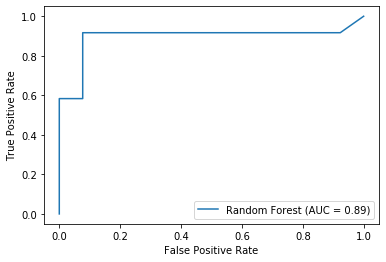

In [36]:
metrics.plot_roc_curve(forest_clf, X_test, y_test, name="Random Forest")
plt.show()

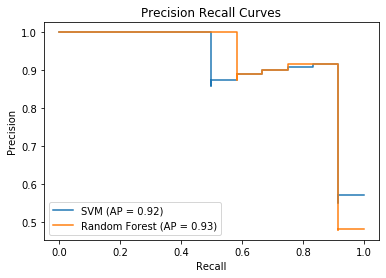

In [50]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_score)
ap = metrics.average_precision_score(y_test, y_score)

fig, ax = plt.subplots()
metrics.plot_precision_recall_curve(svc_clf, X_test, y_test, name="SVM", ax=ax)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name="Random Forest")
disp.plot(ax=ax)
ax.set(title="Precision Recall Curves")
ax.legend()

plt.show()

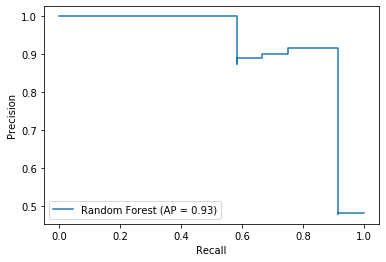

In [51]:
PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name="Random Forest").plot()

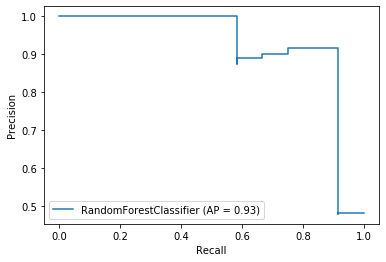

In [27]:
metrics.plot_precision_recall_curve(forest_clf, X_test, y_test)
plt.show()